In [2]:
library("TSP")
concorde_path("~/concorde/TSP")

source("functions.R")




dataETSP <- read_TSPLIB("/home/LC/mailo01/TSP-ML-Approach/src/Official_Cases/ei8246.tsp")

dataTSP <- as.TSP(dataETSP)

found: concorde concorde.c concorde.o 


In [3]:
concorde_result <- 206171

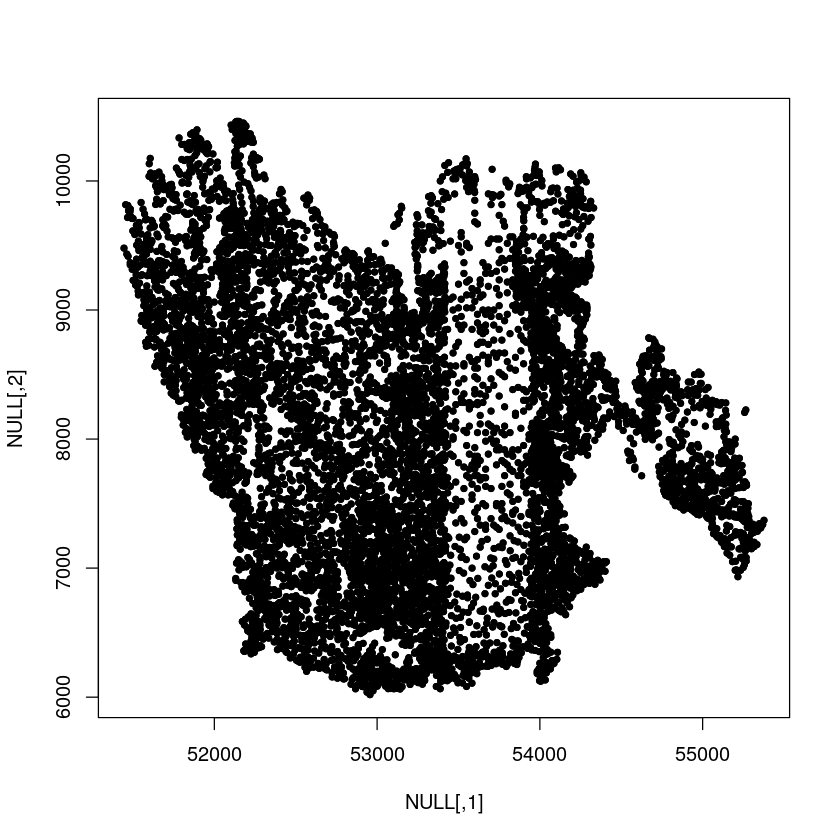

In [99]:
library("hash")
library("sets")

pointSet <- hash()
noPts <- length(dataETSP)/2
horizontal_based <- list()
vertical_based <-list()


radius <- 18
plot(dataETSP, pch=20)
symbols(dataETSP, circles=rep(radius,noPts), add=T, inches=F)

In [100]:
print("preparing necessary data")
start_time <- Sys.time()
for (i in 1:noPts){
    pointSet[[toString(i)]] <- tuple(dataETSP[i], dataETSP[i+noPts])
    element <- list(i, dataETSP[[i]],dataETSP[[i+noPts]])
    horizontal_based <- append( horizontal_based, list(element))
    vertical_based <- append(vertical_based, list(element))
}

horizontal_based <- horizontal_based[order(sapply(horizontal_based, '[[', 2))]
vertical_based <- vertical_based[order(sapply(vertical_based,'[[',3))]
vertices_mat <- as.matrix(as.TSP(dataETSP))
done <- list 
current_tree <- list()
checklist <-(c(1:noPts))


end_time <-Sys.time()
print("total time to pre process data")
add<- end_time - start_time
total<-  add
print(add)
print("begin clustering vertices based on given radius")
start_time <- Sys.time()
while (length(checklist) != 0){

    branch <- list()

    old_branch_len<- length(branch)

    startPt = checklist[1]
    branch<-append(branch, startPt)
    done <- append(done, startPt)

    counter =1

    while(old_branch_len != length(branch)){

        current_branch_len <- length(branch)

        start <-old_branch_len+1
        pts_to_connect <- c(branch[start:current_branch_len])

        checklist <-checklist[!checklist %in% pts_to_connect]

        old_branch_len= current_branch_len

        for (connect_pt in pts_to_connect){
            vPt1 <-values(pointSet, keys=connect_pt) 
            possible_connect <- get_possible_pts(vPt1[[1]],vPt1[[2]], radius, horizontal_based,vertical_based, done)

            for (comparePt in possible_connect){

                if (!comparePt %in%branch){

                    vPt2 <-values(pointSet, keys=comparePt) 

                    if (dist_pts(vPt1,vPt2) <= 2*radius){

                        branch<-append(branch,comparePt)
                        done <- append(done,comparePt)
                        checklist <-checklist[!checklist %in% c(comparePt)]


                    } 
                } 
            }
        }
        counter <- counter +1

    }
    current_tree <- append(current_tree, list(branch))
}
end_time <- Sys.time()

print("finished clustering. Total processing time: ")
add<- end_time - start_time
total<- total + add
print(add)


branch_no <- length(current_tree)
print("number of branches in tree")
print(branch_no)
if (branch_no <= 2){
    print("number of clusters smaller or equal 2. Concorde Solver will halt")
    cont <- FALSE
} else {
    print("generating new tsp instances")
    start_time <- Sys.time()
    cluster_mat <- matrix(rep(0,branch_no^2),nrow=branch_no)

    #for each branch, need to find the shortest distance 
    #remember, have to put points already taken out of consideration

    connections <- hash()

    for (branch_index in 1:branch_no){
        #other branches to be compared to
            for (branch_compare_ind in 1:length(current_tree)){
                if (has.key(sprintf("%s-%s",branch_index,branch_compare_ind),connections) == FALSE){

                if (branch_index != branch_compare_ind){
                    minimum_dist <- Inf
                    connect_pts <- NULL

                    for (vertex in current_tree[[branch_index]]){
                        
                        for (vertex_compare in current_tree[[branch_compare_ind]]){
                            if (minimum_dist == Inf){
                                minimum_dist <- vertices_mat[vertex, vertex_compare]
                                connect_pts <- list(vertex, vertex_compare)
                            } else{
                                distance <- vertices_mat[vertex, vertex_compare]
                                if (distance <= minimum_dist){
                                    minimum_dist <- distance
                                    connect_pts <- list(vertex, vertex_compare)
                                } 
                            }
                        } 
                    }

                    connections[[sprintf("%s-%s",branch_index,branch_compare_ind)]] <-  tuple(connect_pts[[1]],connect_pts[[2]])
                    connections[[sprintf("%s-%s",branch_compare_ind,branch_index)]] <-  tuple(connect_pts[[2]],connect_pts[[1]])
                    #append distances to matrix
                    cluster_mat <- add_data_mat(branch_index,branch_compare_ind,minimum_dist, cluster_mat)

                }
            }
        }
    }
    tsp_cluster <- as.TSP(cluster_mat)
    end_time <- Sys.time()
    
    print("cluster TSP generated. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving the cluster-based TSP")
    start_time <- Sys.time()

    cluster_tour <- solve_TSP(tsp_cluster, method="concorde")
    end_time <- Sys.time()
    print("cluster tour solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print(" computing suitable endpoints")
    start_time <- Sys.time()
    end_points_list<- end_points_det(cluster_tour, connections)
    end_time <- Sys.time()
    print("end points determined. total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("solving for ALL sub cases")
    start_time <- Sys.time()

    all_solutions <- list()
    for (branchNo in 1:length(current_tree)){
        print("subcase")
        print(branchNo)
        pts  <- data.frame(x=c(), y=c())
        if ( length(current_tree[[branchNo]]) <=2){
            print("trivial. number of points smaller or equal 2")
            if (length(current_tree[[branchNo]]) == 1){

                all_solutions <- append(all_solutions, list(list(1)))
            }

            if (length(current_tree[[branchNo]]) == 2){
                all_solutions <- append(all_solutions, list(list(2,1)))
            }

        }else{
            
            end_points <- end_points_list[[toString(branchNo)]]
            end_points_pos <-list()
            
            print("generating TSP instance for sub case")
            for (pt in current_tree[[branchNo]]){
                if (pt %in% end_points){
                    end_points_pos <- append(end_points_pos, match(pt,current_tree[[branchNo]] ))
                }
                pt_data <- values(pointSet, keys=pt)
                pts <- rbind(pts, c(pt_data[[1]],pt_data[2]))           

            }
            tsp_subcase <- TSP(dist(pts))
            end_points <- end_points_list[[toString(branchNo)]]
            
            
            tsp_subcase <- add_end_points(tsp_subcase, end_points_pos)

            
            print("using concorde solver.")
            cont <- TRUE
            while (cont == TRUE){
                tour <-  solve_TSP(tsp_subcase)
                if (tour_length(tour, tsp_subcase) != Inf){
                    cont <- FALSE
                }
            }
            print("done. append the current solution")

            all_solutions <- append(all_solutions, list(as.list(as.integer(tour))))
        }
    }
    end_time <- Sys.time()
    print("all subcases are solved. Total processing time")
    add<- end_time - start_time
    total<- total + add
    print(add)
    
    print("merging") 
    start_time <- Sys.time()
    to_global_subtours <- to_global(all_solutions, current_tree)
    all_subtours <- filter_before_merge(to_global_subtours,end_points_list)
    merged_tour <-merge_all(all_subtours, cluster_tour)
    end_time <- Sys.time()
    add<- end_time - start_time
    total<- total + add
    print(add)
    print("process ends. Total time")
    print(total)
}



[1] "preparing necessary data"
[1] "total time to pre process data"
Time difference of 9.738786 secs
[1] "begin clustering vertices based on given radius"
[1] "finished clustering. Total processing time: "
Time difference of 4.801554 mins
[1] "number of branches in tree"
[1] 854
[1] "generating new tsp instances"
[1] "cluster TSP generated. Total processing time"
Time difference of 45.50844 mins
[1] "solving the cluster-based TSP"
Used control parameters:
clo	 =  
exe	 =  /home/LC/mailo01/concorde/TSP/concorde
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


[1] "cluster tour solved. Total processing time"
Time difference of 2.483226 mins
[1] " computing suitable endpoints"
[1] "end points determined. total processing time"
Time difference of 0.1957231 secs
[1] "solving for ALL sub cases"
[1] "subcase"
[1] 1
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 2
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 3
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 4
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 5
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [33] is not a sub-multiple or multiple of the number of columns [34]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 6
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 7
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 8
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 9
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 10
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 11
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 12
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [60] is not a sub-multiple or multiple of the number of columns [61]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 13
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 14
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 15
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 16
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 17
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 18
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 19
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [570] is not a sub-multiple or multiple of the number of columns [571]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 20
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 21
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 22
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 23
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 24
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 25
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 26
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [26] is not a sub-multiple or multiple of the number of columns [27]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 27
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 28
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 29
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [24] is not a sub-multiple or multiple of the number of columns [25]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 30
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 31
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 32
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 33
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 34
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 35
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 36
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 37
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 38
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [97] is not a sub-multiple or multiple of the number of columns [98]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 39
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 40
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 41
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 42
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 43
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 44
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 45
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 46
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 47
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 48
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 49
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 50
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 51
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 52
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 53
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [29] is not a sub-multiple or multiple of the number of columns [30]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 54
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 55
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 56
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 57
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 58
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [29] is not a sub-multiple or multiple of the number of columns [30]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 59
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 60
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 61
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 62
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 63
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 64
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 65
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 66
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 67
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 68
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 69
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 70
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 71
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [23] is not a sub-multiple or multiple of the number of columns [24]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 72
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 73
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [86] is not a sub-multiple or multiple of the number of columns [87]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 74
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 75
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 76
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 77
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [127] is not a sub-multiple or multiple of the number of columns [128]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 78
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 79
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 80
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 81
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 82
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [96] is not a sub-multiple or multiple of the number of columns [97]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 83
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 84
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 85
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 86
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 87
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [29] is not a sub-multiple or multiple of the number of columns [30]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 88
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 89
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [26] is not a sub-multiple or multiple of the number of columns [27]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 90
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 91
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 92
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 93
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 94
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 95
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [46] is not a sub-multiple or multiple of the number of columns [47]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 96
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 97
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [27] is not a sub-multiple or multiple of the number of columns [28]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 98
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 99
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 100
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [302] is not a sub-multiple or multiple of the number of columns [303]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 101
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 102
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [17] is not a sub-multiple or multiple of the number of columns [18]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 103
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [16] is not a sub-multiple or multiple of the number of columns [17]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 104
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [32] is not a sub-multiple or multiple of the number of columns [33]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 105
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 106
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 107
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 108
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 109
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 110
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 111
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 112
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 113
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [74] is not a sub-multiple or multiple of the number of columns [75]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 114
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 115
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 116
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 117
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 118
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 119
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 120
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 121
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [42] is not a sub-multiple or multiple of the number of columns [43]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 122
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 123
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 124
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 125
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 126
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 127
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 128
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 129
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 130
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 131
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [89] is not a sub-multiple or multiple of the number of columns [90]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 132
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 133
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 134
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 135
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 136
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 137
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 138
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 139
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 140
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 141
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [33] is not a sub-multiple or multiple of the number of columns [34]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 142
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [34] is not a sub-multiple or multiple of the number of columns [35]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 143
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 144
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 145
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 146
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 147
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 148
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 149
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 150
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 151
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 152
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 153
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 154
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 155
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 156
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 157
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 158
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 159
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 160
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 161
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 162
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [82] is not a sub-multiple or multiple of the number of columns [83]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 163
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 164
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 165
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 166
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 167
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 168
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 169
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 170
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 171
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 172
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 173
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 174
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 175
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 176
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 177
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 178
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 179
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 180
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 181
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 182
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 183
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 184
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [1770] is not a sub-multiple or multiple of the number of columns [1771]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 185
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 186
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 187
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 188
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 189
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 190
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 191
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 192
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 193
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 194
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 195
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 196
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 197
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 198
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 199
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 200
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 201
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 202
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 203
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 204
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 205
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 206
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 207
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 208
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 209
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 210
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 211
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 212
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 213
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 214
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 215
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 216
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 217
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 218
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 219
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 220
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 221
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 222
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 223
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 224
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 225
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 226
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 227
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 228
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 229
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 230
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 231
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 232
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 233
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 234
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 235
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 236
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 237
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 238
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 239
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 240
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 241
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 242
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 243
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [32] is not a sub-multiple or multiple of the number of columns [33]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 244
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 245
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 246
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 247
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 248
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 249
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 250
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 251
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 252
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 253
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 254
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 255
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 256
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 257
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 258
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 259
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 260
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 261
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 262
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 263
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 264
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 265
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 266
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 267
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 268
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 269
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 270
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 271
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 272
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 273
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 274
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 275
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 276
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 277
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 278
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 279
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 280
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 281
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 282
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 283
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 284
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [16] is not a sub-multiple or multiple of the number of columns [17]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 285
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 286
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 287
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 288
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 289
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 290
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 291
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 292
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 293
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 294
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 295
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 296
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [17] is not a sub-multiple or multiple of the number of columns [18]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 297
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 298
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 299
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 300
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 301
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 302
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 303
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 304
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 305
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [27] is not a sub-multiple or multiple of the number of columns [28]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 306
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 307
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 308
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 309
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 310
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [22] is not a sub-multiple or multiple of the number of columns [23]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 311
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 312
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [15] is not a sub-multiple or multiple of the number of columns [16]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 313
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 314
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 315
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 316
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 317
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 318
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 319
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 320
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 321
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 322
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [27] is not a sub-multiple or multiple of the number of columns [28]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 323
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 324
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 325
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 326
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 327
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 328
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 329
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 330
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 331
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [266] is not a sub-multiple or multiple of the number of columns [267]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 332
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 333
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 334
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 335
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 336
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 337
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 338
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 339
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 340
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 341
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 342
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 343
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 344
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 345
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 346
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 347
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 348
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 349
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 350
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 351
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 352
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [33] is not a sub-multiple or multiple of the number of columns [34]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 353
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 354
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 355
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 356
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 357
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 358
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 359
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 360
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [37] is not a sub-multiple or multiple of the number of columns [38]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 361
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 362
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 363
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 364
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 365
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 366
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 367
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 368
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 369
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 370
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 371
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 372
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 373
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 374
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 375
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 376
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 377
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 378
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 379
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 380
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 381
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 382
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 383
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 384
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [25] is not a sub-multiple or multiple of the number of columns [26]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 385
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 386
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 387
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 388
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 389
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 390
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 391
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 392
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [29] is not a sub-multiple or multiple of the number of columns [30]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 393
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 394
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 395
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 396
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 397
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [11] is not a sub-multiple or multiple of the number of columns [12]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 398
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 399
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 400
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 401
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 402
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 403
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 404
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 405
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 406
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 407
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 408
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 409
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 410
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 411
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 412
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 413
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 414
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 415
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 416
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 417
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 418
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 419
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 420
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 421
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 422
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 423
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 424
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 425
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 426
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 427
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 428
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 429
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 430
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 431
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 432
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 433
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 434
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 435
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 436
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 437
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 438
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 439
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 440
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 441
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 442
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 443
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 444
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 445
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 446
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 447
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 448
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 449
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 450
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 460
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 461
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 462
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 463
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 464
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 465
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 466
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 467
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 468
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 469
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 470
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 471
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 472
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 473
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 474
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 475
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 476
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 477
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 478
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 479
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 480
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 481
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 482
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 483
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 484
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 485
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 486
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 487
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 488
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 489
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 490
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 491
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 492
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 493
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 494
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 495
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 496
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 497
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 498
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 499
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 500
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 501
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 502
[1] "generating TSP instance for 

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 503
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 504
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 505
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 506
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 507
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 508
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 509
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 510
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 511
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 512
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 513
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 514
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 515
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 516
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 517
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 518
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 519
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 520
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 521
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 522
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 523
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 524
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 525
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 527
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 528
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 529
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 530
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 531
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 532
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 533
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 534
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 535
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 536
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 537
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 538
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 539
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 540
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 541
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 542
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 543
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 544
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 545
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 546
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 547
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 548
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 549
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 550
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 551
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 552
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 553
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 554
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 555
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 556
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 557
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 558
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 559
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 560
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 567
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 568
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 569
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 570
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 571
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 572
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 573
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 574
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 575
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 576
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 577
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 578
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 579
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 580
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 581
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 582
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 583
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 584
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 585
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 586
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 587
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 588
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 589
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 590
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 591
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 592
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 593
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 594
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 595
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 596
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 597
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 598
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 599
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 600
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 601
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 602
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 603
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 604
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 605
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 606
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 607
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 608
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 609
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 610
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 611
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 612
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 613
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 614
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 615
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 616
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 617
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 618
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 619
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 620
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 621
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 622
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 623
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 624
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 625
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 626
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 627
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 628
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 629
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 630
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 631
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 632
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 633
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 639
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 640
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 641
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 642
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 643
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 644
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 645
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 646
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 647
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 648
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 649
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 650
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 651
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 652
[1] "trivial. number of points sm

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 661
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 662
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 663
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 664
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 665
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 666
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 667
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [367] is not a sub-multiple or multiple of the number of columns [368]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 668
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 669
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 670
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [17] is not a sub-multiple or multiple of the number of columns [18]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 671
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 672
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 673
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [13] is not a sub-multiple or multiple of the number of columns [14]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 674
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 675
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 676
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 677
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 678
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 679
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 680
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 681
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [8] is not a sub-multiple or multiple of the number of columns [9]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 682
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 683
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 684
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [23] is not a sub-multiple or multiple of the number of columns [24]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 685
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 686
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 687
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 688
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 689
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 690
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 691
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 692
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 693
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 694
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 695
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 696
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 697
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 698
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 699
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 700
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 701
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 702
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 703
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 704
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 705
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 706
[1] "generating TSP instance for 

Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 707
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 708
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 709
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 710
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [12] is not a sub-multiple or multiple of the number of columns [13]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 711
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 712
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 713
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 714
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 715
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 716
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 717
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 718
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [719] is not a sub-multiple or multiple of the number of columns [720]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 719
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 720
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 721
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 722
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 723
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 724
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 725
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 726
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 727
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 728
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 729
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [89] is not a sub-multiple or multiple of the number of columns [90]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 730
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 731
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 732
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 733
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 734
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [26] is not a sub-multiple or multiple of the number of columns [27]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 735
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 736
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 737
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 738
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 739
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 740
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 741
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 742
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 743
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 744
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 745
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 746
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 747
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 748
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 749
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 750
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 751
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 752
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 753
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 754
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 755
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 756
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 757
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 758
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [41] is not a sub-multiple or multiple of the number of columns [42]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 759
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 760
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 761
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 762
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 763
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 764
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 765
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 766
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 767
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 768
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 769
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 770
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 771
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 772
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 773
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 774
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 775
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [5] is not a sub-multiple or multiple of the number of columns [6]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 776
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 777
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 778
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 779
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 780
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 781
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 782
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 783
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 784
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [9] is not a sub-multiple or multiple of the number of columns [10]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 785
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 786
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 787
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 788
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 789
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [106] is not a sub-multiple or multiple of the number of columns [107]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 790
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 791
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 792
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 793
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 794
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 795
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 796
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 797
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 798
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [62] is not a sub-multiple or multiple of the number of columns [63]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 799
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [37] is not a sub-multiple or multiple of the number of columns [38]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 800
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 801
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 802
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 803
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 804
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 805
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 806
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 807
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [333] is not a sub-multiple or multiple of the number of columns [334]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 808
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 809
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 810
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 811
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [3] is not a sub-multiple or multiple of the number of columns [4]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 812
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 813
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 814
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 815
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 816
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 817
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 818
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 819
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 820
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 821
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 822
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 823
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 824
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 825
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 826
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 827
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 828
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [4] is not a sub-multiple or multiple of the number of columns [5]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 829
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 830
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 831
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [14] is not a sub-multiple or multiple of the number of columns [15]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 832
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 833
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 834
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 835
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 836
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 837
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 838
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 839
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 840
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [20] is not a sub-multiple or multiple of the number of columns [21]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 841
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [18] is not a sub-multiple or multiple of the number of columns [19]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 842
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [6] is not a sub-multiple or multiple of the number of columns [7]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 843
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 844
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 845
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 846
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 847
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [7] is not a sub-multiple or multiple of the number of columns [8]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 848
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 849
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [10] is not a sub-multiple or multiple of the number of columns [11]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 850
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 851
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 852
[1] "generating TSP instance for sub case"


Warning message in matrix(const, ncol = p + n, nrow = n, dimnames = list(label, :
“data length [21] is not a sub-multiple or multiple of the number of columns [22]”


[1] "using concorde solver."
[1] "done. append the current solution"
[1] "subcase"
[1] 853
[1] "trivial. number of points smaller or equal 2"
[1] "subcase"
[1] 854
[1] "trivial. number of points smaller or equal 2"
[1] "all subcases are solved. Total processing time"
Time difference of 13.35817 secs
[1] "merging"
   [1]    1   20   16   44   28   37   25   36   18   14    4   12    8    7
  [15]    2    5   11   45   51   58   74   65  110  118  123   94  126  200
  [29]  202  227  244  216  222  229  213  241  273  287  299  342  338  304
  [43]  246  165  154  108  114  105   80   70   73   57   33   27   34   35
  [57]   43   61   67   99  151  187  194  201  236  289  325  279  296  366
  [71]  314  277  233  204  181  168  224  197  149  128  131  160  137  162
  [85]  172  193  226  245  302  382  443  686  859  773  833  781  748  759
  [99]  791  666  677  621  622  510  469  450  560  573  530  528  489  517
 [113]  457  430  361  322  301  293  259  228  242  225  232  240  2

[1] "evaluation of result: "
[1] "the ratio of this heuristics result over concorde result is: "


[1] 1.119253

[1] "the absolute value of the difference between 2 results"


[1] 24586.56

[1] "the time it takes for the heuristic method is "


Time difference of 3191.146 secs

[1] "this is the plot of the heuristic produced tour: "


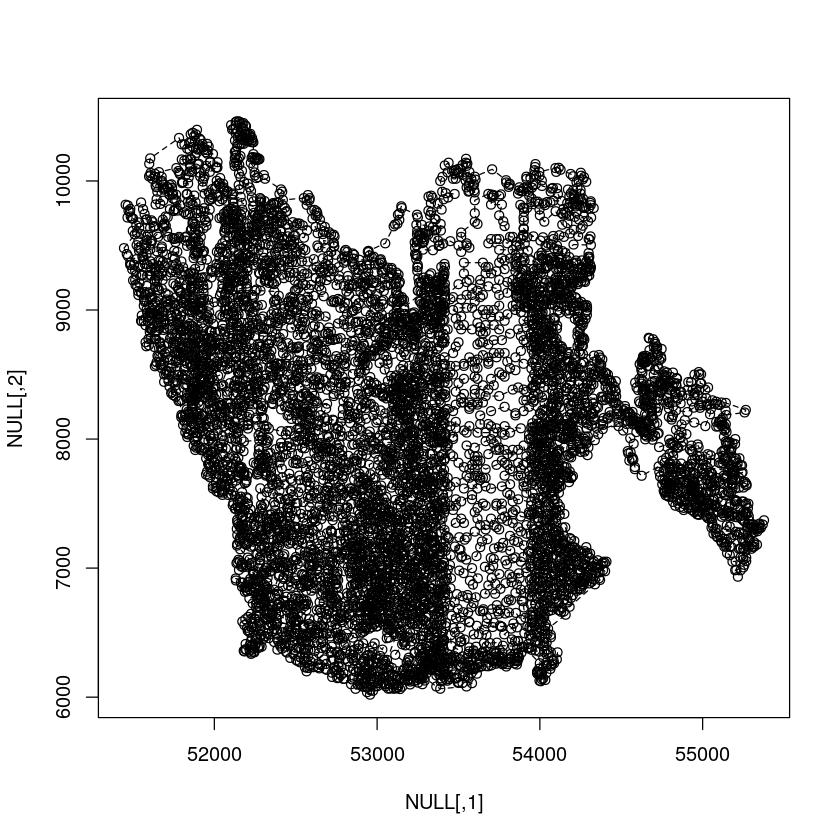

In [101]:
print("evaluation of result: ")
print("the ratio of this heuristics result over concorde result is: ")
tour_length(as.TOUR(merged_tour),dataETSP)/concorde_result

print("the absolute value of the difference between 2 results")
tour_length(as.TOUR(merged_tour),dataETSP) - concorde_result

print("the time it takes for the heuristic method is ")
total


print("this is the plot of the heuristic produced tour: ")
plot(dataETSP, as.TOUR(merged_tour))

In [130]:
library("TSP")
concorde_path("~/concorde/LINKERN")

processing_time <- list()
percentage_over <- list()

for (i in 1:10){
    start_time <- Sys.time()
    heuristic_tour <- solve_TSP(dataTSP, method="linkern")
    end_time <- Sys.time()
    heuristic_time <- end_time-start_time
    processing_time <- append(processing_time, as.numeric(toString(heuristic_time))*60)
    percentage <- (tour_length(heuristic_tour,dataETSP)/concorde_result - 1)*100
    percentage_over <- append(percentage_over, percentage)
}

found: linkern linkern_fixed.c linkern_fixed.o linkern_path.c linkern_path.o linkern.a linkern.c linkern.o 
Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


Used control parameters:
exe	 =  /home/LC/mailo01/concorde/LINKERN/linkern
clo	 =  
precision	 =  6
verbose	 =  TRUE
keep_files	 =  FALSE


Warning message in .prepare_dist_concorde(x, MAX, control$precision):
“Concorde/Linken can only handle distances represented as integers. Converting the provided distances to integers with precison 4. This may lead to rounding errors.”


In [131]:
processing_time

[[1]]
[1] 203.2461

[[2]]
[1] 203.1038

[[3]]
[1] 202.7306

[[4]]
[1] 202.2421

[[5]]
[1] 201.3638

[[6]]
[1] 201.7817

[[7]]
[1] 201.9868

[[8]]
[1] 202.1484

[[9]]
[1] 201.9445

[[10]]
[1] 202.6789

In [132]:
percentage_over

[[1]]
[1] 0.4466325

[[2]]
[1] 0.4422802

[[3]]
[1] 0.4762443

[[4]]
[1] 0.4819248

[[5]]
[1] 0.4607785

[[6]]
[1] 0.222785

[[7]]
[1] 0.4871144

[[8]]
[1] 0.4748086

[[9]]
[1] 0.1837472

[[10]]
[1] 0.4489595

In [112]:
tour_length(heuristic_tour,dataETSP)

[1] NA